# Homework 4


### Silvia Cabellos 



#### Course: Introduction to applied data science (PHYS247) Spring 2020




## Problem 1: LendingClub
#### Build a model to predict whether or not a borrower will pay back their loan 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import numpy as np
# from sklearn.model_selection import cross_val_score
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

Using TensorFlow backend.


## a) 
#### First perform data cleaning. Convert all categorical variables to numeric variables. Extract the zip-code information from the borrowers' address and consider that as one of your features.

In [2]:
data=pd.read_csv(r'C:\Users\scabellos\OneDrive - Urban Science\User Documents\MastersDegree\AppliedDataScience\Homework4\LendingClub.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395219 entries, 0 to 395218
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             395219 non-null  float64
 1   term                  395219 non-null  object 
 2   int_rate              395219 non-null  float64
 3   installment           395219 non-null  float64
 4   grade                 395219 non-null  object 
 5   sub_grade             395219 non-null  object 
 6   home_ownership        395219 non-null  object 
 7   annual_inc            395219 non-null  float64
 8   verification_status   395219 non-null  object 
 9   loan_status           395219 non-null  object 
 10  purpose               395219 non-null  object 
 11  dti                   395219 non-null  float64
 12  earliest_cr_line      395219 non-null  object 
 13  open_acc              395219 non-null  float64
 14  pub_rec               395219 non-null  float64
 15  

#### Let's start with our data exploration - "loan_status" is our target feature - Let's see how balanced is the set 

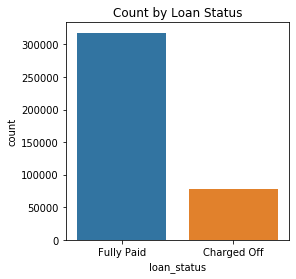

In [4]:

plt.figure(figsize=(4, 4))
sns.countplot(data['loan_status'])
plt.title('Count by Loan Status')
plt.show()

####  The Target feature is unbalalanced. We have to take this into account when we split the data set for training and testing. 
#### Next, we are going to look for duplicates or missing values. There isnt any dup or missing value in this data set 

In [5]:
# checking for duplicates 

data=data.drop_duplicates()
data.shape

(395219, 23)

In [6]:
#checking for missing values 

nulls=data.isnull().sum()
print("The number of nulls per feature is", '\n')
print(nulls)

The number of nulls per feature is 

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
home_ownership          0
annual_inc              0
verification_status     0
loan_status             0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
dtype: int64


#### Let's find how many unique values have the categorical features in the set 

In [7]:
categorical=['term','grade', 'sub_grade',
       'home_ownership','verification_status', 'loan_status',
       'purpose', 'earliest_cr_line', 'initial_list_status',
       'application_type', 'address']
for c in categorical:
    print(c,data[c].nunique()) 


term 2
grade 7
sub_grade 35
home_ownership 6
verification_status 3
loan_status 2
purpose 14
earliest_cr_line 684
initial_list_status 2
application_type 3
address 392898


#### Start with Address - we are going to extract the zipcode to use it as feature

#### Using ZIP instead of address - we have 10 different ZIPs  

In [8]:
data['zip']=data['address'].str.slice(start=-5,)
data['zip'].unique()

array(['22690', '05113', '00813', '11650', '30723', '70466', '29597',
       '48052', '86630', '93700'], dtype=object)

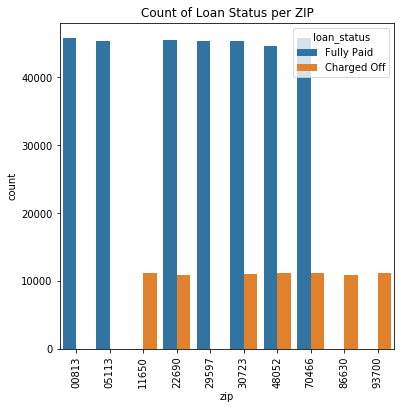

In [9]:
plt.figure(figsize=(6, 6))
sns.countplot(x="zip", hue="loan_status", data=data)
plt.title('Count of Loan Status per ZIP')
plt.xticks(rotation=90)
plt.show()

ZIP is definitely an important feature to understand where are the highest risk of unpaid loans 

#### Credit Line History  - First I am going to extract the year, then analyze the distribution, After that, I will remove some of the earlier years as they have very few records in the data set and I will bucket the years into decades for easier classification 

In [10]:
data['earliest_year_line']=data['earliest_cr_line'].str.slice(start=-4,)
data['earliest_year_line'].unique()

array(['1990', '2004', '2007', '2006', '1999', '2005', '1994', '1997',
       '1984', '1995', '2001', '1982', '1996', '2000', '2003', '2008',
       '1998', '2002', '2009', '1992', '1988', '2010', '1986', '2012',
       '1978', '1993', '1983', '1989', '1991', '2011', '1980', '1981',
       '1987', '1985', '1967', '1972', '1969', '1979', '1965', '1977',
       '1974', '1976', '1975', '1971', '2013', '1964', '1970', '1973',
       '1963', '1960', '1966', '1961', '1968', '1958', '1955', '1953',
       '1959', '1962', '1944', '1956', '1951', '1957', '1950', '1954',
       '1948'], dtype=object)

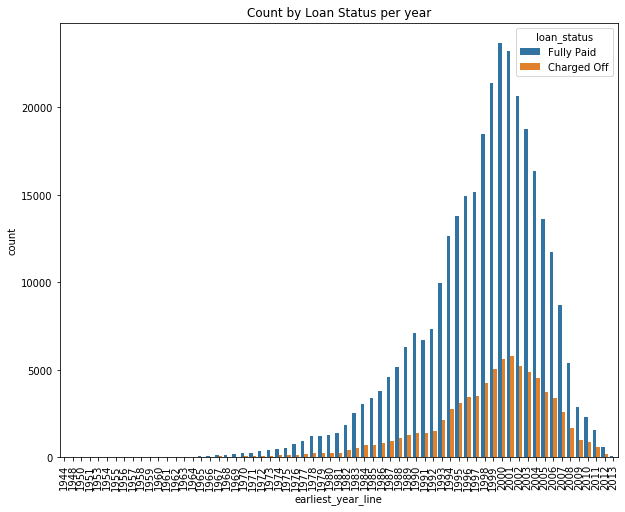

In [11]:
plt.figure(figsize=(10, 8))
sns.countplot(x="earliest_year_line", hue="loan_status", data=data)
plt.title('Count by Loan Status per year')
plt.xticks(rotation=90)
plt.show()

In [12]:
#we are going to remove some records from the sample
# remove from 1944 to 1970 
print(len(data[data['earliest_year_line']<'1970']))
data=data.drop(data[data['earliest_year_line']<'1970'].index,axis=0)

1166


In [13]:
#Create buckets of tean years ( decades ) for easy classification Equal-width: equal bucket range ( as partition rule) 

data['earliest_year_line']= data['earliest_year_line'].astype(int)
import numpy as np
bins = np.array([1970,1980,1990,2000,2013])
data["earliest_decade_creditline"] = pd.cut(data['earliest_year_line'], bins, include_lowest=True)

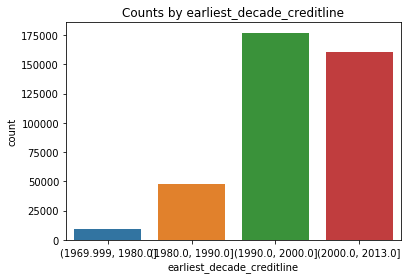

In [14]:
sns.countplot(data['earliest_decade_creditline'])
plt.title('Counts by earliest_decade_creditline')
plt.show()

### Purpose 

In [15]:
data['purpose'].unique()

array(['vacation', 'debt_consolidation', 'credit_card',
       'home_improvement', 'small_business', 'major_purchase', 'other',
       'medical', 'wedding', 'car', 'moving', 'house', 'educational',
       'renewable_energy'], dtype=object)

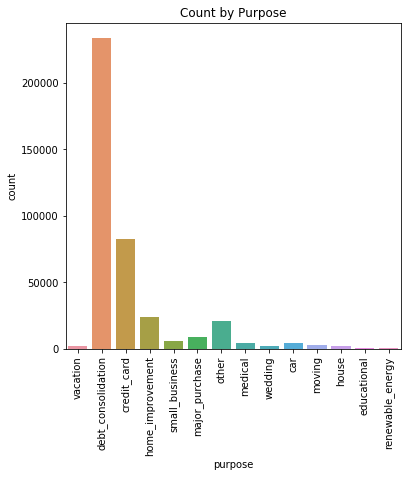

In [16]:
plt.figure(figsize=(6,6))
sns.countplot(data['purpose'])
plt.title('Count by Purpose')
plt.xticks(rotation=90)
plt.show()

#### We are going to group some of the purposes with fewer volume of loans for easier clasification. And group the PURPOSE into 3 categories

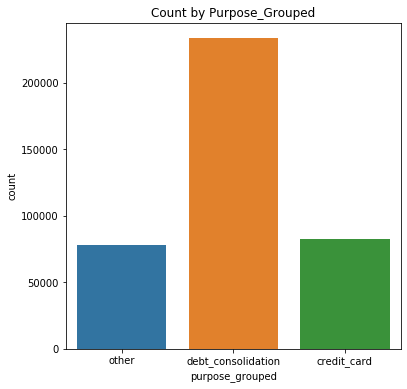

In [17]:


data["purpose_grouped"]=data["purpose"]

other=["vacation","home_improvement","small_business","major_purchase",
       'medical', 'wedding', 'car', 'moving', 'house', 'educational',
       'renewable_energy']
for i in other:
    data["purpose_grouped"]=data["purpose_grouped"].replace(i,"other")  

data["purpose_grouped"].value_counts()

plt.figure(figsize=(6,6))
sns.countplot(data['purpose_grouped'])
plt.title('Count by Purpose_Grouped')
#plt.xticks(rotation=90)
plt.show()


### Grade

In [18]:
data["grade"].unique()

array(['B', 'A', 'C', 'E', 'D', 'F', 'G'], dtype=object)

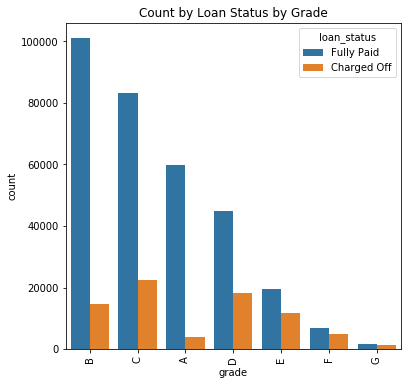

Rate of Paid loans by grade:



A    0.937273
B    0.874446
C    0.788406
D    0.711526
E    0.626447
F    0.572294
G    0.522039
Name: grade, dtype: float64

In [19]:

plt.figure(figsize=(6, 6))

sns.countplot(x="grade", hue="loan_status", data=data, order=['B', 'C', 'A','D','E','F','G'])
plt.title('Count by Loan Status by Grade')
plt.xticks(rotation=90)

plt.show()

paidbygrade=data[data["loan_status"].str.contains('Fully Paid')]['grade'].value_counts().sort_index()
unpaidbygrade=data[data["loan_status"].str.contains('Charged Off')]['grade'].value_counts().sort_index()

print ("Rate of Paid loans by grade:\n")
bygrade= pd.concat([paidbygrade, unpaidbygrade], axis=1, sort=False)
bygrade.iloc[:,0]/(bygrade.iloc[:,1]+bygrade.iloc[:,0])


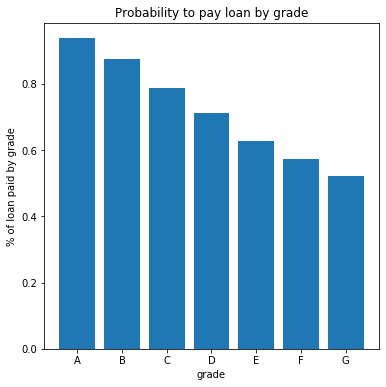

In [20]:
plt.figure(figsize=(6, 6))
y=bygrade.iloc[:,0]/(bygrade.iloc[:,1]+bygrade.iloc[:,0])
x = list(bygrade.index)
plt.bar(x,y)
plt.xlabel('grade', fontsize=10)
plt.ylabel('% of loan paid by grade', fontsize=10)
plt.title('Probability to pay loan by grade')
plt.show()



#### Home Ownership  
#### We are going to drop the three descriptions with very few rows ( ANY OTHER and NONE ) 

In [21]:
data["home_ownership"].value_counts()  

MORTGAGE    197375
RENT        159083
OWN          37454
OTHER          109
NONE            29
ANY              3
Name: home_ownership, dtype: int64

In [22]:
# we are going to drop the three descriptions with very few rows 

data = data.drop(data[(data['home_ownership']=='ANY')].index,axis=0)
data = data.drop(data[(data['home_ownership']=='OTHER')].index,axis=0)
data = data.drop(data[(data['home_ownership']=='NONE')].index,axis=0)

data["home_ownership"].value_counts()


MORTGAGE    197375
RENT        159083
OWN          37454
Name: home_ownership, dtype: int64

#### verification_status. Both verified and not verified have a similar rate of payment 
#### I will remove this feature as is  probably not very important predictor -

In [23]:
data["verification_status"].value_counts()

Verified           138781
Source Verified    130973
Not Verified       124158
Name: verification_status, dtype: int64

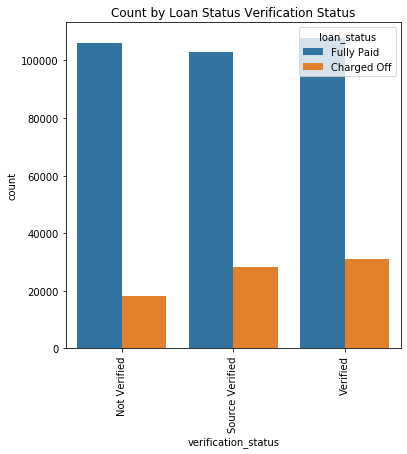

In [24]:
plt.figure(figsize=(6, 6))
sns.countplot(x="verification_status", hue="loan_status", data=data)
plt.title('Count by Loan Status Verification Status')
plt.xticks(rotation=90)
plt.show()

#### initial_list_status  - Leave feature as is 

In [25]:
data["initial_list_status"].value_counts()

f    236533
w    157379
Name: initial_list_status, dtype: int64

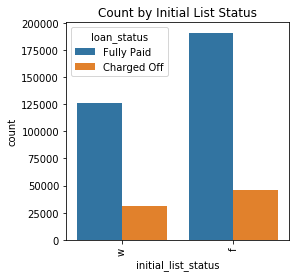

In [26]:
plt.figure(figsize=(4, 4))
sns.countplot(x="initial_list_status", hue="loan_status", data=data)
plt.title('Count by Initial List Status')
plt.xticks(rotation=90)
plt.show()

#### Application_type  The number of JOINT and DIRECT PAY is very small. 

#### I will remove this column from the set 

In [27]:
data["application_type"].value_counts()

INDIVIDUAL    393202
JOINT            425
DIRECT_PAY       285
Name: application_type, dtype: int64

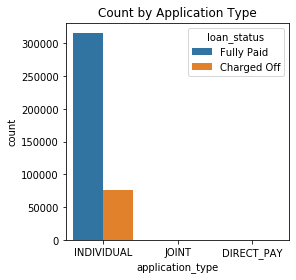

In [28]:
plt.figure(figsize=(4, 4))
sns.countplot(x="application_type", hue="loan_status", data=data)
plt.title('Count by Application Type')
plt.show()

Now that are are done analyzing the data - we are going to Remove some columns from the set as indicated above and proceed with the encoding 

The columns I am removing are 

'sub_grade','application_type','address','purpose','earliest_cr_line','earliest_year_line','verification_status'


In [30]:
#remove from set 

data_drop=data.copy()
data_drop= data_drop.drop(['sub_grade','application_type','address','purpose','earliest_cr_line','earliest_year_line','verification_status'] ,1)
#data= data.drop('earliest_year_line',1)
data_drop.head()

,loan_amnt,term,int_rate,installment,grade,home_ownership,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mort_acc,pub_rec_bankruptcies,zip,earliest_decade_creditline,purpose_grouped
0,10000.0,36 months,11.44,329.48,B,RENT,117000.0,Fully Paid,26.24,16.0,0.0,36369.0,41.8,25.0,w,0.0,0.0,22690,"(1980.0, 1990.0]",other
1,8000.0,36 months,11.99,265.68,B,MORTGAGE,65000.0,Fully Paid,22.05,17.0,0.0,20131.0,53.3,27.0,f,3.0,0.0,05113,"(2000.0, 2013.0]",debt_consolidation
2,15600.0,36 months,10.49,506.97,B,RENT,43057.0,Fully Paid,12.79,13.0,0.0,11987.0,92.2,26.0,f,0.0,0.0,05113,"(2000.0, 2013.0]",credit_card
3,7200.0,36 months,6.49,220.65,A,RENT,54000.0,Fully Paid,2.60,6.0,0.0,5472.0,21.5,13.0,f,0.0,0.0,00813,"(2000.0, 2013.0]",credit_card
4,24375.0,60 months,17.27,609.33,C,MORTGAGE,55000.0,Charged Off,33.95,13.0,0.0,24584.0,69.8,43.0,f,1.0,0.0,11650,"(1990.0, 2000.0]",credit_card


In [31]:
#first we make a copy of the data for a backup  
data_clean=data_drop.copy()
data_clean.head()

,loan_amnt,term,int_rate,installment,grade,home_ownership,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mort_acc,pub_rec_bankruptcies,zip,earliest_decade_creditline,purpose_grouped
0,10000.0,36 months,11.44,329.48,B,RENT,117000.0,Fully Paid,26.24,16.0,0.0,36369.0,41.8,25.0,w,0.0,0.0,22690,"(1980.0, 1990.0]",other
1,8000.0,36 months,11.99,265.68,B,MORTGAGE,65000.0,Fully Paid,22.05,17.0,0.0,20131.0,53.3,27.0,f,3.0,0.0,05113,"(2000.0, 2013.0]",debt_consolidation
2,15600.0,36 months,10.49,506.97,B,RENT,43057.0,Fully Paid,12.79,13.0,0.0,11987.0,92.2,26.0,f,0.0,0.0,05113,"(2000.0, 2013.0]",credit_card
3,7200.0,36 months,6.49,220.65,A,RENT,54000.0,Fully Paid,2.60,6.0,0.0,5472.0,21.5,13.0,f,0.0,0.0,00813,"(2000.0, 2013.0]",credit_card
4,24375.0,60 months,17.27,609.33,C,MORTGAGE,55000.0,Charged Off,33.95,13.0,0.0,24584.0,69.8,43.0,f,1.0,0.0,11650,"(1990.0, 2000.0]",credit_card


### Now we are going to proceed to encode all  the categorical values . 

#### Using onehotencoding 

#### The strategy is to convert each category value into a new column and assigns a 1 or 0 (True/False) value to the column. This has the benefit of not weighting a value improperly but does have the downside of adding more columns to the data set.

#### We dont have so many features so it is going to work fine in our data set. 

In [32]:
data_clean["loan_status_code"] = np.where(data_clean["loan_status"]=='Fully Paid', 1, 0)
data_clean["loan_status_code"].value_counts()
data_clean=data_clean.drop(["loan_status"],axis=1)

In [33]:

data_clean=pd.get_dummies(data_clean, columns=["term"])
data_clean=pd.get_dummies(data_clean, columns=["grade"])
data_clean=pd.get_dummies(data_clean, columns=["home_ownership"])
data_clean=pd.get_dummies(data_clean, columns=["purpose_grouped"])
data_clean=pd.get_dummies(data_clean, columns=["earliest_decade_creditline"])
data_clean=pd.get_dummies(data_clean, columns=["initial_list_status"])
data_clean=pd.get_dummies(data_clean, columns=["zip"])

data_clean=data_clean.rename(columns={"earliest_decade_creditline_(1969.999, 1980.0]": "creditline_1970_1980", 
                   "earliest_decade_creditline_(1980.0, 1990.0]": "creditline_1980_1990",
                   "earliest_decade_creditline_(1990.0, 2000.0]": "creditline_1990_2000",
                   "earliest_decade_creditline_(2000.0, 2013.0]": "creditline_2000_2013"})

data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393912 entries, 0 to 395218
Data columns (total 44 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   loan_amnt                           393912 non-null  float64
 1   int_rate                            393912 non-null  float64
 2   installment                         393912 non-null  float64
 3   annual_inc                          393912 non-null  float64
 4   dti                                 393912 non-null  float64
 5   open_acc                            393912 non-null  float64
 6   pub_rec                             393912 non-null  float64
 7   revol_bal                           393912 non-null  float64
 8   revol_util                          393912 non-null  float64
 9   total_acc                           393912 non-null  float64
 10  mort_acc                            393912 non-null  float64
 11  pub_rec_bankruptcies      

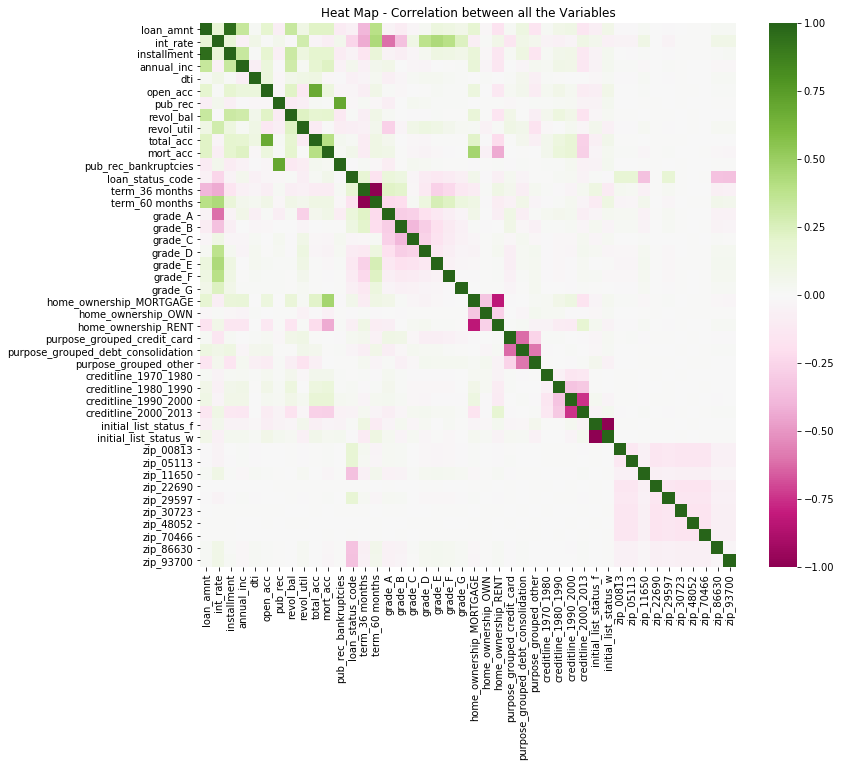

In [38]:

plt.figure(figsize=(12,10))
sns.heatmap(data_clean.corr(),annot=False,cmap="PiYG")
plt.title('Heat Map - Correlation between all the Variables')
plt.show()

#### Where we can see areas for pairs of variables that are purple (inversely correlated ) or green ( correlated). Areas that are white show little correlation. 
#### We can see for example that our target variable "loan_status_code" has a relationship with certain zip codes, and loan grade. But it has little to do with the credit history or some other of the numerical variables. 

# b) 
### Split the data to training (70%) and test(30%) sample.

In [ ]:
print("Positive examples =",len(data_clean[data_clean['loan_status_code']==1]))
print("Negative examples =",len(data_clean[data_clean['loan_status_code']==0]))
print(f"Proportion of positive examples = {len(data_clean[data_clean['loan_status_code']==1])/len(data_clean)* 100:.2f}%")

#### We have an imbalanced dataset. This is a classification task where 80% of the data is in one class.  That can lead to problems: an accuracy of 90% can be skewed if you have no predictive power on the other category of data! 
#### One tactic to get over the hump is to resample the data set and create a balance data set where we have predictive power on the 2 categories this tecnique is called "Stratified Random Assignment" -  It is a process of sampling where each class (training or test data) is equally represented in the sample. That allows the model to focus on the difference between the patterns of each class and identifies outliers.

#### Following the below steps :

1. Get All Negative data 
2. Shuffle and Reset indexes for all the Negative data 
3. Do the same for Positive 
4. Merge 70% of the Positives and 70% of the Negatives from the data sets above  - and build my training set
5. Merge the remaining 30% of the Positives and the 30% of the Negatives  - and build my testing test 



In [40]:
# get negative 
negative=data_clean[data_clean['loan_status_code']==0]
# shuffle
negative = negative.sample(frac = 1) 
#reset index 
negative=negative.reset_index(drop=True)

#same for positive 
positive=data_clean[data_clean['loan_status_code']==1]
# shuffle
positive = positive.sample(frac = 1) 
#reset index 
positive=positive.reset_index(drop=True)


In [41]:
round(len(positive)*0.7)
len(positive)-round(len(positive)*0.7)
training_positive=positive.loc[0:round(len(positive)*0.7)]
print("Len Training Positive : ",len(training_positive))
testing_positive=positive.loc[round(len(positive)*0.7)+1:len(positive)]
print("Len Testing Positive : ",len(testing_positive))

round(len(negative)*0.7) 
len(negative)-round(len(negative)*0.7)
training_negative=negative.loc[0:round(len(negative)*0.7)]
print("Len Training Negative : ",len(training_negative))
testing_negative=negative.loc[round(len(negative)*0.7)+1:len(negative)]
print("Len Testing Negative : ",len(testing_negative))



Len Training Positive :  221695
Len Testing Positive :  95011
Len Training Negative :  54045
Len Testing Negative :  23161



With this method, I end up with a balanced set that follows the class representation of the model in both training and testing. 

In [42]:
training=pd.concat([training_positive,training_negative])
training=training.reset_index(drop=True)
testing=pd.concat([testing_positive,testing_negative])
testing=testing.reset_index(drop=True)


# shuffle again 
training = training.sample(frac = 1) 
testing=testing.sample(frac = 1) 

In [44]:
X_train=training.loc[:, data_clean.columns !='loan_status_code'].values
X_test=testing.loc[:, data_clean.columns !='loan_status_code'].values

y_train = training.loc[:, data_clean.columns =='loan_status_code'].values.flatten()
y_test = testing.loc[:, data_clean.columns =='loan_status_code'].values.flatten()

print(f"Original data shapes: {X_train.shape, X_test.shape}")

print(f"Original target value shapes: {y_train.shape, y_test.shape}")


Original data shapes: ((275740, 43), (118172, 43))
Original target value shapes: ((275740,), (118172,))


## c) 
### Use sklearn.preprocessing.MinMaxScaler function to normalize all the features for both training and test sample.

In [46]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

## d)

### Build a sequential model using neural-network library Keras. Use four Dense layers (including input and output layers) along with dropout regularization to reduce overfitting.  You need to decide on the number of neurons in each layer.

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

#### For this model, I applied Dropout of 20% to hidden neurons in the body of the network model.

In [48]:
neurons=[3,4,5,6,7,8,9,10]
acc=[]
neu=[]

for ne in neurons:
      model_n= Sequential([layers.Dense(43,activation='softmax'),
                               #To avoid overfitting we want that 20% of the weights do not get updated in each iteration
                                layers.Dropout(0.2),
                                layers.Dense(ne, activation='softmax'),
                                layers.Dropout(0.2),
                                layers.Dense(ne, activation='softmax'),
                                layers.Dropout(0.2),
                                layers.Dense(1, activation='sigmoid'),])
      model_n.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy']) 
      model_n.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),batch_size=32,epochs=5,verbose=0)
      acc.append(model_n.history.history['accuracy'][4])
      neu.append(ne)

### Lets sort the number of neurons that provides highest accuracy. They are al very similar so I'll choose the ANN with 10 neurons. 

In [49]:
d={'Acuracy':acc,'Neurons per Layer':neu}
history=pd.DataFrame(d)
history.sort_values('Acuracy',ascending=False)

,Acuracy,Neurons per Layer
7,0.886672,10
6,0.885849,9
4,0.885740,7
5,0.884565,8
3,0.880561,6
2,0.867778,5
1,0.866468,4
0,0.857311,3


### For that model, I run the charts to visualize metrics ( accuracy and loss)  for training and testing sets 

In [51]:
model10=Sequential()
model10.add(Dense(43,activation='softmax'))  # input 
model10.add(Dropout(0.2))
model10.add(Dense(10,activation='softmax'))
model10.add(Dropout(0.2))
model10.add(Dense(10,activation='softmax'))
model10.add(Dropout(0.2))
model10.add(Dense(1,activation='sigmoid')) #output 
model10.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy']) 

In [52]:
model10.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),batch_size=32,epochs=30,verbose=0)


In [87]:

model10.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             multiple                  1892      
_________________________________________________________________
dropout_24 (Dropout)         multiple                  0         
_________________________________________________________________
dense_33 (Dense)             multiple                  440       
_________________________________________________________________
dropout_25 (Dropout)         multiple                  0         
_________________________________________________________________
dense_34 (Dense)             multiple                  110       
_________________________________________________________________
dropout_26 (Dropout)         multiple                  0         
_________________________________________________________________
dense_35 (Dense)             multiple                 

## d) 
### Evaluate the performance of your model.

Accuracy of the model with 10 neurons is: 88.72%


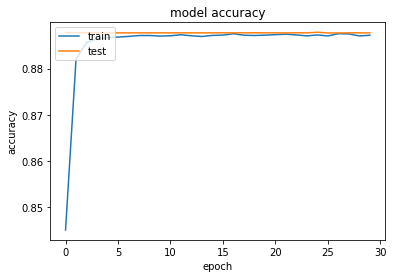

Loss of the model with 10 neurons is: 26.43%


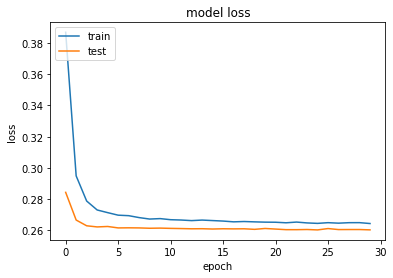

In [54]:

print('Accuracy of the model with 10 neurons is: 'f"{(model10.history.history['accuracy'][29])*100:.2f}%")

# summarize history for accuracy
plt.plot(model10.history.history['accuracy'])
plt.plot(model10.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss

print('Loss of the model with 10 neurons is: 'f"{(model10.history.history['loss'][29])*100:.2f}%")
plt.plot(model10.history.history['loss'])
plt.plot(model10.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [64]:
# make a prediction
predicted = model10.predict_classes(X_test)
predicted=predicted.reshape(118172)


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [79]:
TP,TN,FP,FN=0,0,0,0
for i in range(len(y_test)):
    if y_test[i]==1:
        if predicted[i]==1:
            TP+=1
        if predicted[i]==0:
            FN+=1
    if y_test[i]==0:
        if predicted[i]==1:
            FP+=1
        if predicted[i]==0:
            TN+=1

In [83]:
#confusion matrix 
print(np.array([[TP,FP],[FN,TN]]))

[[94988 13248]
 [   23  9913]]


In [85]:
precision=TP/(TP+FP)
print('precision: 'f"{precision*100:.2f}%")

recall=TP/(TP+FN)
print('recall: 'f"{recall*100:.2f}%")

F1_score=2*precision*recall/(precision+recall)
print('F1_score: 'f"{F1_score*100:.2f}%")

accuracy=(TP+TN)/(TP+FP+FN+TN)
print('accuracy: 'f"{accuracy*100:.2f}%")

precision: 87.76%
recall: 99.98%
F1_score: 93.47%
accuracy: 88.77%


For this analysis, Precision is more important than Recall and should be improved. These metrics are showing a precision of 87% abd shows  13248  False Positives, meaning that our model is classifying them is good candidates for a loan, even though y_test shows they will not.  